# Part 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optilibrary as libopt

In [2]:
from scipy.linalg import norm

In [ ]:
X_train, y_train, X_test, y_test, _ = libopt.importData(p=0.2)
n, d = X_train.shape
# print(X_train.shape)
lbda = 1. / n ** (0.5)

In [4]:
#Create models using data
pblinreg = libopt.RegPb(X_train, y_train, lbda, loss='l2')

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

In [6]:
import optilibrary as ot

## Question 1: 
- Implement stochastic gradient and 

- compare its performance with that of your gradient descent implementation from Part 1 on the same problem and dataset. 
- What happens when both methods are run using the same stepsize? 
- Do your observations confirm what has been discussed during the lecture?

We consider the same dataset as in Part 1 and compare the performance of the stochastic descent and gradient descent technques. To ensure comparability, the following parameters are fixed:
- Number of epochs (eg. number of accesses to the gradient) is set to 30
- $x_0$ the initial estimate is set to all-zeros$.

As the SG method is not always guaranteed to converge, we opt to compare the methods by making use of a decreasing step size.
- The step parameter is fixed to $\alpha_k=\frac{0.2}{2^k}$ at iteration $k$.

In [ ]:
nb_epochs = 50
x0 = np.zeros(d)

import time
elapsed = []

x = []; obj=[]; its=[]
batches = [1, int(n/500), int(n/100), int(n/10), int(n/2), n]
btitle = ['1', 'n/500', 'n/100', 'n/10', 'n/2', 'n']

for i in range(len(batches)):
    nbset = batches[i]
    # print(f'niter={int((nb_epochs*n)/nbset)}, nb={nbset}')
    st = time.time()
    x_a, obj_a, nits_a = ot.stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int((nb_epochs*n)/nbset),nb=nbset)
    et = time.time()
    elapsed.append(et-st)
    x.append(x_a)
    obj.append(obj_a)
    its.append(nits_a)
    
#To even out
obj = np.array([np.array(o[-nb_epochs-1:-1]) for o in obj])
obj.shape

Plot

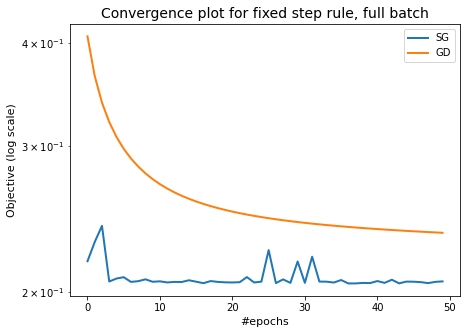

In [14]:
plt.figure(figsize=(7, 5))
plt.semilogy(obj[0], lw=2)
plt.semilogy(obj[-1], lw=2)
plt.title("Convergence plot for fixed step rule, full batch", fontsize=14)
plt.xlabel("#epochs", fontsize=11)
plt.ylabel("Objective (log scale)", fontsize=11)
plt.legend(('SG', 'GD'));

This run beautifully illustrates typical characteristics of the 2 algorithms when compared one to the other:

As discussed in class, the stochastic gradient algorithm is not a descent method; behaviour which is clearly observed here in that the objective value is sometimes increasing over successive epochs. The oscillatory phase following a phase of quick descent corresponds to class discussion in that we observe the method stalling when the steps get too small to make a big improvment.

Conversely, gradient descent is guaranteed to descend over every successive iteration and we observe this behaviour clearly below.

For this method, and for a fixed number of epochs, it seems that SG performs better than the method from which it was derived.



## Question 2: 
Find a value for the batch size that realizes a good compromise between gradient descent and stochastic gradient.

We consider several different batch sizes, each for a fixed number of epochs and compare this to the gradient descent method (where the batch size is merely $n$, the number of entries).

$$\text{batch} = \left\{1, \frac{n}{100}, \frac{n}{10}, \frac{n}{5}, n \right\}$$

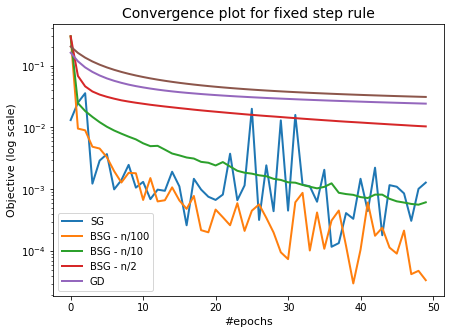

In [15]:
# Plot the comparison of variants of batch SGD with the same stepsize rule
plt.figure(figsize=(7, 5))
for i in range(len(batches)):
    plt.semilogy(obj[i]-f_min_lin, lw=2)
plt.title("Convergence plot for fixed step rule", fontsize=14)
plt.xlabel("#epochs", fontsize=11)
plt.ylabel("Objective (log scale)", fontsize=11)

plt.legend(['SG', 'BSG - n/100', 'BSG - n/10', 'BSG - n/2', 'GD']);


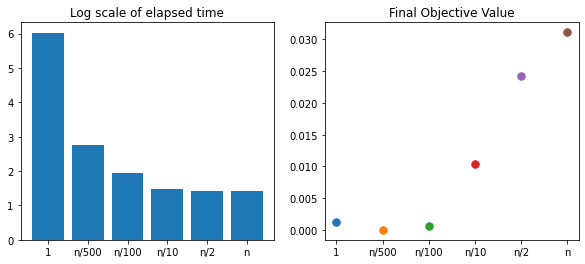

In [28]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.bar(btitle, np.log(elapsed))
plt.title('Log scale of elapsed time')

plt.subplot(1,2,2)
for i in range(len(obj)):
    plt.plot(i, obj[i][-1]-f_min_lin, '.-', markersize=15)
plt.xticks(np.arange(6), btitle)

plt.title('Final Objective Value');
# print(obj[:,-1]);

BSG with n/100 seems to perform almost exactly as well as vanilla SG, but with a runtime comparable to smaller batch size. 

We conclude that batch stochastic gradient with a batch size of n/100 would be satisfactory as a compromise between SG and GD. 

## *Question 3:* 

_Compare your stochastic gradient method with one of the advanced variants seen in class on your selected problem. Discuss your results, and what interpretation you can draw from them._

We consider SG and compare it with the technique of averaging - a technique designed to reduce the variance. 
To compare the methods, run 5 repetitions of 50 epochs each for a batch-size fixed to $\frac{n}{100}$ as determined above and a step size rule as before. 

In [ ]:
# Comparison of stochastic gradient with and without averaging
nb_epochs = 50
x0 = np.zeros(d)

nruns = 5

obj_a = []
obj_b = []

nbset = int(n/100)
niter=int(nb_epochs*n/nbset)

for i in range(nruns):
    # Run standard stochastic gradient without averaging
    _, oa, _ = ot.stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=niter, nb=nbset)
    obj_a.append(oa)
    # Run stochastic gradient with averaging
    _, ob, _= ot.stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=niter, nb=nbset,average=1)
    obj_b.append(ob)


In [19]:
obj_a = np.array(obj_a)
obj_b = np.array(obj_b)

Plotted below on the left is the convergence of each of the 5 runs for SG and SG-averaging respectively.

To the right is the average of each method, with the standard deviation coloured in. We observe that SG-Avg has markedly less variance than that of vanilla SG

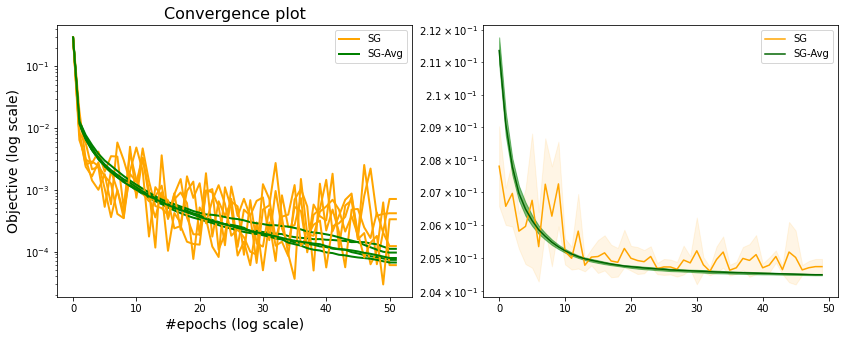

In [22]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
for i in range(nruns):
    plt.semilogy(obj_a[i]-f_min_lin,color='orange',lw=2)
    plt.semilogy(obj_b[i]-f_min_lin,color='g', lw=2)
    # plt.semilogy(obj_c[i]-f_min_lin,color='indianred', lw=2)

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(('SG', 'SG-Avg'))

plt.subplot(1,2,2)
t = np.arange(nb_epochs)
ma = np.mean(obj_a[:,2:], axis=0)
sda = np.std(obj_a[:,2:], axis=0)
plt.plot(t, ma, 'orange')
plt.fill_between(t, ma - sda, ma + sda, color='orange', alpha=0.1)

mb = np.mean(obj_b[:,2:], axis=0)
sdb = np.std(obj_b[:,2:], axis=0)
plt.plot(t, mb, 'darkgreen')
plt.fill_between(t, mb - sdb, mb + sdb, color='g', alpha=0.5)

plt.yscale('log')
plt.yticks([])
plt.legend(('SG', 'SG-Avg'));

As mentioned before, SG is *not* a descent method and so not guaranteed to descend at each iteration. It will, however, descend on average. By averaging over iterates, the SG-Avg method is essentially enforcing the 'descent' behaviour of SGD but still retaining its very good convergence results. Moreover, averaging also decreases the variance in the method. 